# Image registration from scratch with Harris detector 


In [1]:
from __future__ import print_function
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
import math
from scipy.ndimage import gaussian_filter
%matplotlib inline

Let's work on a mountain photo !

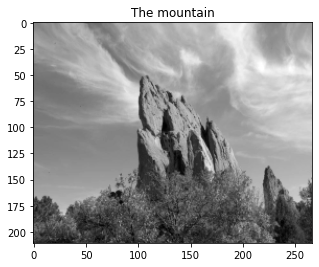

In [2]:
img   = cv2.imread('mountains.png')
img   = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

scale_percent = 30 
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
# resize image
img_resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

plt.figure(figsize=(5,5));
plt.title("The mountain");
plt.imshow(img_resized,cmap='gray');

## 1. The Bilateral Filter

### Custom Gaussian filtering

First of all, I wanted to implement my own gaussian-filtering function. Let's do so :

In [3]:
def g(x,sigma):
    return (1/math.sqrt(2*math.pi*sigma*sigma))*math.exp(-x/(2*sigma*sigma))

def GaussianFiltering(img,sigma,filter_size):
    
    filter_center = math.ceil(filter_size/2)

    
    ## Let's first padd the image correctly
    padd_to_add = math.floor(filter_size/2) ## number of row to add
    img_height = img.shape[0]
    img_width = img.shape[1]    
    padding = np.zeros((img_height+2*padd_to_add,img_width+2*padd_to_add))
    padding[padd_to_add:img_height+padd_to_add,padd_to_add:img_width+padd_to_add] =img
    padded_img = padding
    
    ## Let's create the kernel
    
    filter_distance_matrix=[]
    gauss_matrix=[]
    for i in range(1,filter_size+1):
        resline_distance=[]
        resline_gauss=[]
        for j in range(1,filter_size+1):
            res_distance= (filter_center-i)**2+(filter_center-j)**2
            res_gauss = g(res_distance,sigma)
            
            resline_gauss.append(res_gauss)
            resline_distance.append(res_distance)
            
        filter_distance_matrix.append(resline_distance)
        gauss_matrix.append(resline_gauss)
    
    gauss_matrix=np.array(gauss_matrix)
    gauss_matrix=gauss_matrix/(gauss_matrix.sum())
 
   
    ## Let's filter the image
    
    imgG=[]
    for i in range (padd_to_add,padded_img.shape[0]-padd_to_add):
        resline=[]
        for j in range (padd_to_add,padded_img.shape[1]-padd_to_add):
            res=0
            h2=0
            k2=0
            for k1 in range(int(i-(filter_size-1)/2),int(i+(filter_size-1)/2)+1):
                h2=0
                for h1 in range(int(j-(filter_size-1)/2),int(j+(filter_size-1)/2)+1):
                    
                    Iq = padded_img[k1][h1]
                    res= res+ Iq * gauss_matrix[k2][h2]
                
                   
                    h2+=1
                k2+=1
            resline.append(res)
        imgG.append(resline)
    return(np.array(imgG))

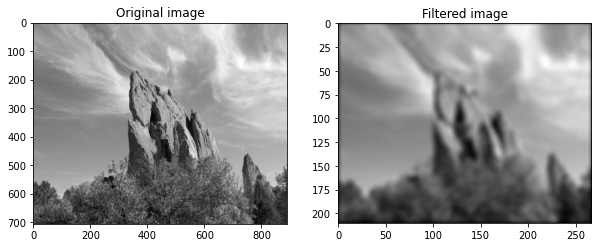

In [4]:
imgG = GaussianFiltering(img_resized,sigma=3,filter_size=9)

plt.figure(figsize=(10,10))
plt.subplot(1,2,2)
plt.imshow(imgG,cmap='gray');
plt.title("Filtered image");
plt.subplot(1,2,1)
plt.title("Original image");
plt.imshow(img,cmap='gray');

This function is efficient in term of filtering, but has a verry poor time of execution. The reason why the scipy implementation is faster is that the Gaussian filtering is parallelized along both axis as the transformation is separable.

The drawback of my custom implementation is then the computational time preventing it from using too large filters.

## Bilateral smoothing

Now let's implement a bilateral filtering

In [5]:
def g(x,sigma):
    return (1/math.sqrt(2*math.pi*sigma*sigma))*math.exp(-x/(2*sigma*sigma))

def g2(x,sigma):
    return (1/math.sqrt(2*math.pi*sigma*sigma))*math.exp(-x*x/(2*sigma*sigma))


def bilateral_filtering(img,sigma,filter_size):
    gaussImg=[]  
    filter_center = math.ceil(filter_size/2)
  
    ## Let's first padd the image correctly
    
    padd_to_add = math.floor(filter_size/2) 
    img_height = img.shape[0]
    img_width = img.shape[1]
    padding = np.zeros((img_height+2*padd_to_add,img_width+2*padd_to_add))
    padding[padd_to_add:img_height+padd_to_add,padd_to_add:img_width+padd_to_add] =img
    padded_img = padding
    
    ## Let's create the kernel
    
    filter_distance_matrix=[]
    gauss_matrix=[]
    for i in range(1,filter_size+1):
        resline_distance=[]
        resline_gauss=[]
        for j in range(1,filter_size+1):
            res_distance= (filter_center-i)**2+(filter_center-j)**2
            res_gauss = g(res_distance,sigma)
            
            resline_gauss.append(res_gauss)
            resline_distance.append(res_distance)
        filter_distance_matrix.append(resline_distance)
        gauss_matrix.append(resline_gauss)
    gauss_matrix=np.array(gauss_matrix)
    gauss_matrix=gauss_matrix/(gauss_matrix.sum())
    
    ## Let's filter the image
    
    imgB=[]
    for i in range (padd_to_add,padded_img.shape[0]-padd_to_add):
        resline=[]
        for j in range (padd_to_add,padded_img.shape[1]-padd_to_add):
            res=0
            Wp=0
            h2=0
            k2=0
            Ip = padded_img[i][j]
            for k1 in range(int(i-(filter_size-1)/2),int(i+(filter_size-1)/2)+1):
                h2=0
                for h1 in range(int(j-(filter_size-1)/2),int(j+(filter_size-1)/2)+1):
                    Iq = padded_img[k1][h1]
                    res +=  Iq * gauss_matrix[k2][h2] *g((Ip/255)**2 - (Iq/255)**2,1)
                    Wp += gauss_matrix[k2][h2]*g((Ip/255)**2 - (Iq/255)**2,1)
                    h2+=1
                k2+=1
            resline.append(res/Wp)
        imgB.append(resline)
    return(np.array(imgB))

Text(0.5, 1.0, 'Bilateral filtering - 5 neighbours')

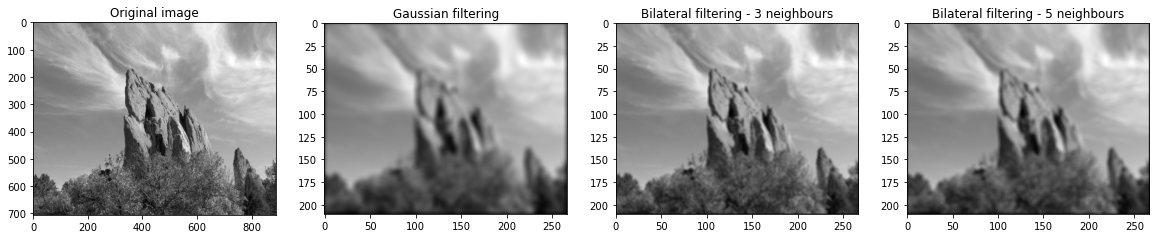

In [6]:
imgB3 = bilateral_filtering(img_resized,sigma=3,filter_size=3)
imgB5 = bilateral_filtering(img_resized,sigma=3,filter_size=5)

plt.figure(figsize=(20,20))
plt.subplot(1,4,1)
plt.imshow(img,cmap='gray')
plt.title("Original image")

plt.subplot(1,4,2)
plt.imshow(imgG,cmap='gray')
plt.title("Gaussian filtering")


plt.subplot(1,4,3)
plt.imshow(imgB3,cmap='gray')
plt.title("Bilateral filtering - 3 neighbours")

plt.subplot(1,4,4)
plt.imshow(imgB5,cmap='gray')
plt.title("Bilateral filtering - 5 neighbours")




Here we clearly can see the advantage of using a Bilateral smoothing over Gaussian smoothing. Indeed the Gaussian smoothing blurs all the image and destroy edges information. On the other hand, bilateral smoothing tries to preserve edges information and blurs only plain parts of the image. 

We also note that the bigger the kernel is, the blurier the image and the edges are.

## 2. The Canny edge detector 



For computational reasons, let's use the scipy implementation of Gaussian smoothing.

In [7]:
def gaussian_smoothing(img,sigma):
    img_gaus = gaussian_filter(img,sigma)
    return (img_gaus)

We use Sobel's kernel to compute the gradient along both axis, and then compute magnitude & direction

In [8]:
def gradient(img):
    kernel_sobel_x =np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
    kernel_sobel_y =np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    
    sobel_x = convolve2d(img/255,kernel_sobel_x)
    sobel_y = convolve2d(img/255,kernel_sobel_y)
    
    magnitude= np.sqrt(sobel_x**2+sobel_y**2)
    direction = (np.arctan(sobel_y/(sobel_x+0.0001)))+(math.pi/2)
    
    return(magnitude,direction)

Let's visualize the output of this function

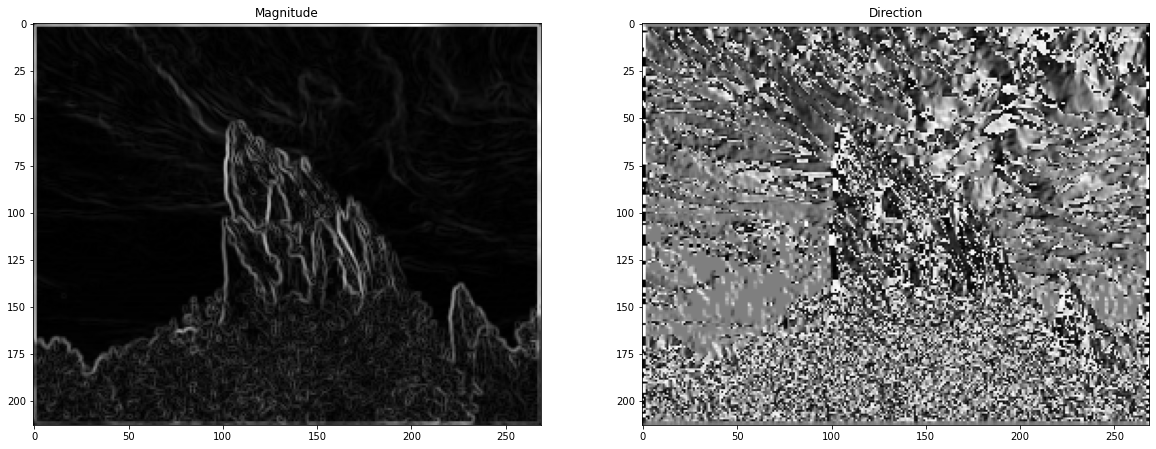

In [9]:
gradient_ = gradient(img_resized)


plt.figure(figsize=(20,20))

plt.subplot(1,2,1)
plt.title("Magnitude")
plt.imshow(gradient_[0],cmap='gray')
plt.subplot(1,2,2)
plt.title("Direction")
plt.imshow(gradient_[1],cmap='gray')

We note that we already have a good idea of the location of edges with the magnitude information, but we can do better. We are going to keep only the most significant gradients. To do so, let's first quantitize or direction into four groups

In [10]:
def quantitizer(direction):


    direction_1  = np.array([direction<(math.pi/8)]).astype(int)
    direction_1 =direction_1*(0)


    direction_2 = np.array([(direction<3*math.pi/8) & (direction>=(math.pi/8))])
    direction_2 =direction_2*(math.pi/4)



    direction_3 = np.array([(direction<5*math.pi/8) & (direction>=(3*math.pi/8))])
    direction_3 =direction_3*(math.pi/2)

    direction_4 = np.array([(direction<7*math.pi/8) & (direction>=(5*math.pi/8))])
    direction_4 =direction_4*(3*math.pi/4)



    direction_5 = np.array([(direction>=(7*math.pi/8))])
    direction_5 =direction_5*0


    direction_final = direction_1+direction_2+direction_3+direction_4+direction_5

    direction_final=np.array(direction_final)[0]

    return(direction_final)

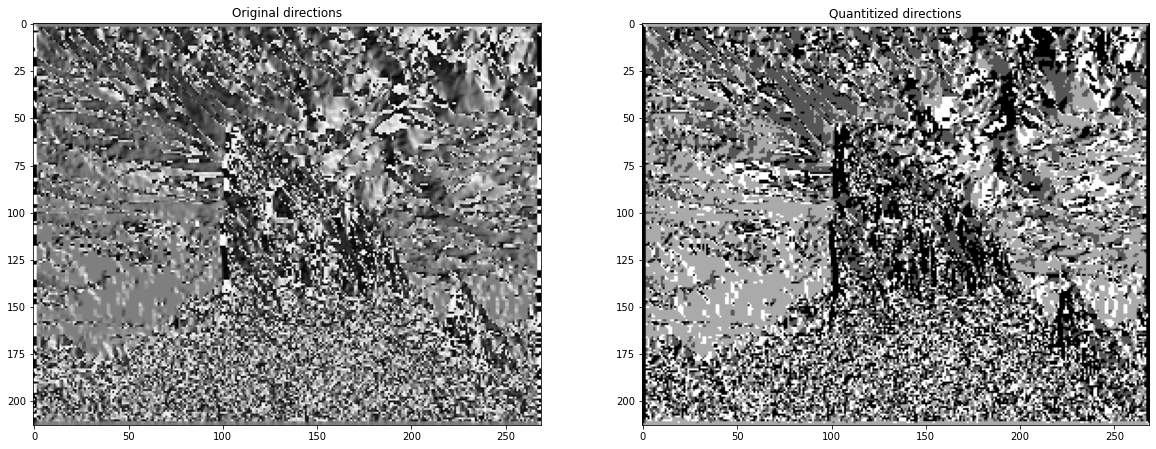

In [11]:
gradient_ = gradient(img_resized)
direction = gradient_[1]
direction_final = quantitizer(direction)

plt.figure(figsize=(20,20))

plt.subplot(1,2,1)
plt.title("Original directions")
plt.imshow(direction,cmap='gray')

plt.subplot(1,2,2)
plt.title("Quantitized directions")
plt.imshow(direction_final,cmap='gray')

Now that have quantitized direction, we can remove gradients with low information compared to his neighbours in the perpendicular direction.

In [12]:
def non_maximum_suppression(g_magnitude, g_dir):
    
    new_g_magnitude = np.copy(g_magnitude)
    
    shape = g_dir.shape
    
    for i in range (1, shape[0]-1):
        for j in range (1, shape[1]-1):
            x=0
            y=0
            direction = g_dir[i][j]
            
            
            if(direction==0):
                x1=0
                y1=1
                x2=0
                y2=-1
            elif(direction==math.pi/4):
                x1=1
                y1=-1
                x2=-1
                y2=1
            elif(direction==math.pi/2):
                x1=-1
                y1=0
                x2=1
                y2=0
            elif(direction==3*math.pi/4):
                x1=1
                y1=1
                x2=-1
                y2=-1
            else:
                print('ERROR')
            
            neigh1= g_magnitude[i+x1][j+y1]
            neigh2= g_magnitude[i+x2][j+y2]
            mag = g_magnitude[i][j]
           
            if(neigh1 >= mag or neigh2>=mag):
             
                new_g_magnitude[i][j]=0
    return(new_g_magnitude)

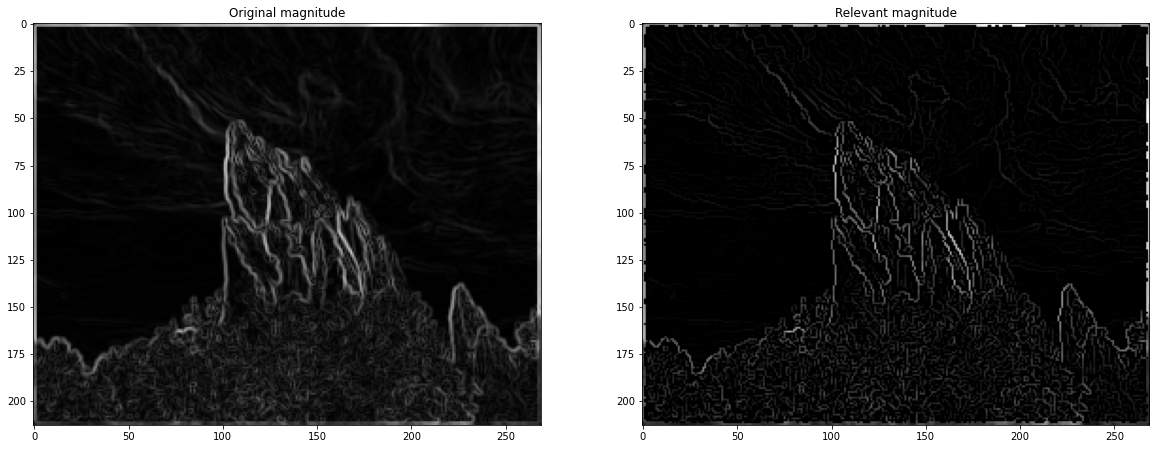

In [13]:
gradient_ = gradient(img_resized)
magnitude = gradient_[0]
direction = gradient_[1]
direction_final = quantitizer(direction)
new_magnitude = non_maximum_suppression(magnitude, direction_final)

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.title("Original magnitude")
plt.imshow(magnitude,cmap='gray')

plt.subplot(1,2,2)
plt.title("Relevant magnitude")
plt.imshow(new_magnitude,cmap='gray')

Let's double-threshold (high&low) this new magnitude

In [14]:
def double_thresholding(mag,thresh_lo, thresh_hi):
    new_mag = np.copy(mag)
    max_grad = mag.max()
    low_trheshold = max_grad*thresh_lo
    high_trheshold = max_grad*thresh_hi
    shape= mag.shape
    for i in range(0,shape[0]):
        for j in range(0,shape[1]):
            magij = mag[i][j]
            if(magij<low_trheshold):
                new_mag[i][j]=0
            elif((magij<high_trheshold) and (magij>=low_trheshold)):
                new_mag[i][j]=1
            else:
                new_mag[i][j]=2
    return( new_mag)

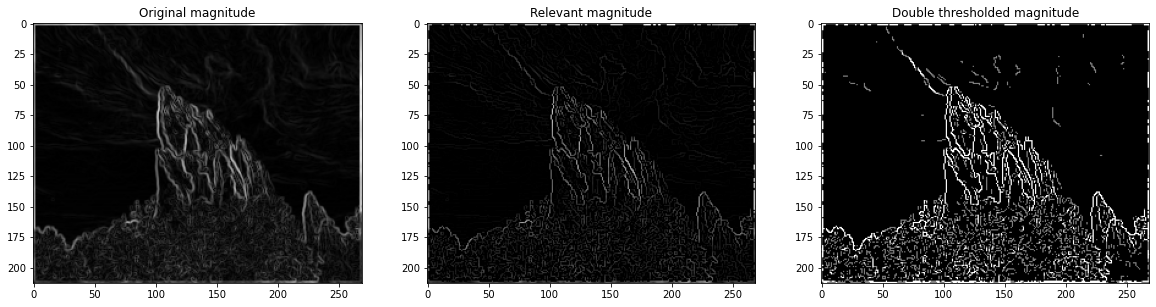

In [15]:
gradient_ = gradient(img_resized)
magnitude = gradient_[0]
direction = gradient_[1]
direction_final = quantitizer(direction)
new_magnitude = non_maximum_suppression(magnitude, direction_final)
double_trhesholded_magnitude = double_thresholding(new_magnitude,0.1, 0.2)

plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.title("Original magnitude")
plt.imshow(magnitude,cmap='gray')

plt.subplot(1,3,2)
plt.title("Relevant magnitude")
plt.imshow(new_magnitude,cmap='gray')

plt.subplot(1,3,3)
plt.title("Double thresholded magnitude")
plt.imshow(double_trhesholded_magnitude,cmap='gray')

Lastly we can connect the edges

In [16]:
def connect_edge(mag):
    new_mag = np.copy(mag)*0
    shape= new_mag.shape
    for i in range (1, shape[0]-1):
        for j in range (1, shape[1]-1):
            if(mag[i][j]==2):
                new_mag[i][j]=1
            if(mag[i][j]==0):
                new_mag[i][j]=0
            else:
                n1=mag[i-1][j-1]
                n2=mag[i][j-1]
                n3=mag[i+1][j-1]
                n4=mag[i-1][j]
                n5=mag[i+1][j]
                n6=mag[i-1][j+1]
                n7=mag[i][j+1]
                n8=mag[i+1][j+1]
                
                if( n1==2 or n2==2 or n3==2 or n4==2 or n5==2 or n6==2 or n8==2 ):
                    new_mag[i][j]=1
                else:
                    new_mag[i][j]=0
    return new_mag

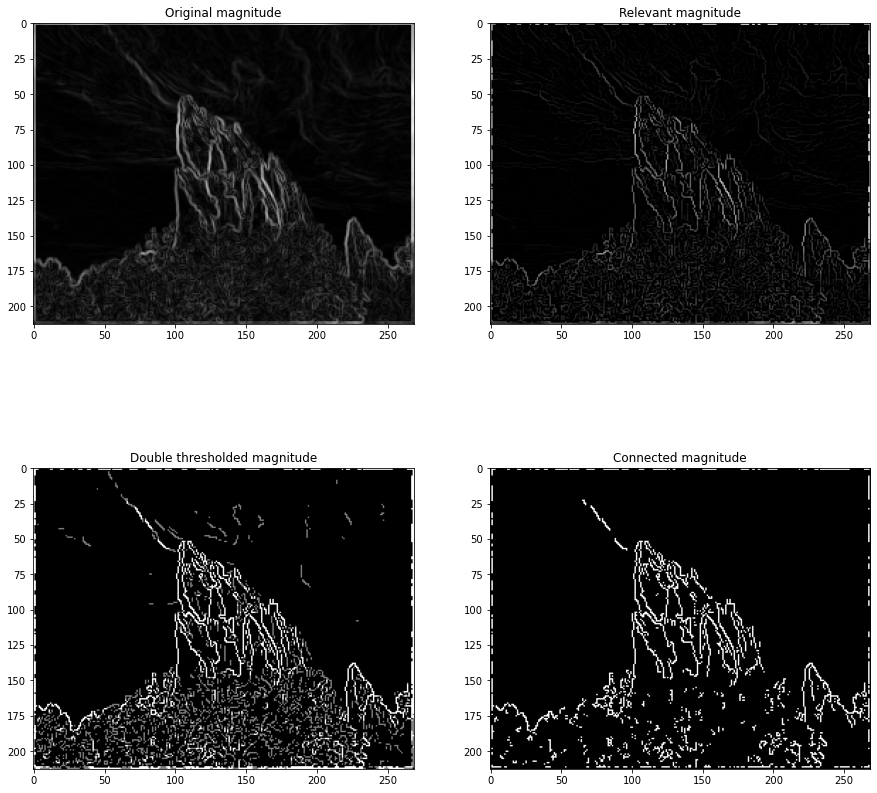

In [17]:
gradient_ = gradient(img_resized)
magnitude = gradient_[0]
direction = gradient_[1]
direction_final = quantitizer(direction)
new_magnitude = non_maximum_suppression(magnitude, direction_final)
double_trhesholded_magnitude = double_thresholding(new_magnitude,0.1, 0.2)
connected_magnitude = connect_edge(double_trhesholded_magnitude)

plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.title("Original magnitude")
plt.imshow(magnitude,cmap='gray')

plt.subplot(2,2,2)
plt.title("Relevant magnitude")
plt.imshow(new_magnitude,cmap='gray')

plt.subplot(2,2,3)
plt.title("Double thresholded magnitude")
plt.imshow(double_trhesholded_magnitude,cmap='gray')

plt.subplot(2,2,4)
plt.title("Connected magnitude")
plt.imshow(connected_magnitude,cmap='gray')

In [18]:
def canny_edge_detector(img,sigma, thresh_lo=0.1, thresh_hi=0.2,smoothing_type='gauss'):
    """
    The Canny edge detector.
    
    Inputs:
        img              The input image
        thresh_lo        The fraction of the maximum gradient magnitude which will 
                         be considered the lo threshold. 
        thresh_hi        The fraction of the maximum gradient magnitude which will
                         be considered the hi threshold. Ideally should be 2x to 3x 
                         thresh_lo.
                         
    Outputs: 
        edge_img         A binary image, with pixels lying on edges marked with a 1, 
                         and others with a 0.
    """
    ##1 
    if(smoothing_type=="gauss"):
        filtered_img= gaussian_smoothing(img,sigma)
    else:
        filtered_img= bilateral_filtering(img,sigma,3)
    ##2
    (mag,direction)= gradient(filtered_img)
    ##3_1
    direction=quantitizer(direction)
    ##3_1
    mag=non_maximum_suppression(mag, direction)
    ##4 
    mag = double_thresholding(mag,thresh_lo,thresh_hi)
    ##5
    mag = connect_edge(mag)    
    return mag

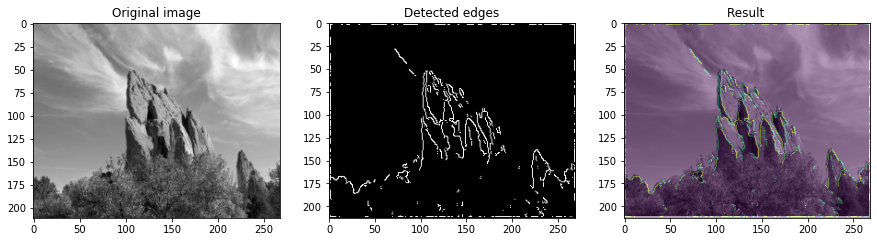

In [19]:
edges = canny_edge_detector(img_resized,0.6, thresh_lo=0.1, thresh_hi=0.2,smoothing_type='gauss')

plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.title("Original image")
plt.imshow(img_resized,cmap='gray')

plt.subplot(1,3,2)
plt.title("Detected edges")
plt.imshow(edges,cmap='gray')

plt.subplot(1,3,3)
plt.title("Result ")
plt.imshow(img_resized,cmap='gray')
plt.imshow(edges,alpha=0.4)

Let's see the influence of the sigma parameter on the result


Text(0.5, 1.0, 'SIGMA = 2')

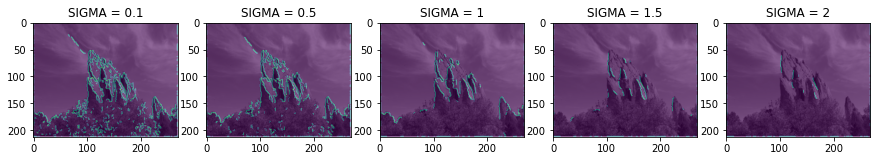

In [20]:
edge_1_gauss = canny_edge_detector(img_resized,sigma=0.1,thresh_lo=0.1,thresh_hi=0.2,smoothing_type='gauss')
edge_2_gauss = canny_edge_detector(img_resized,sigma=0.5,thresh_lo=0.1,thresh_hi=0.2,smoothing_type='gauss')
edge_3_gauss = canny_edge_detector(img_resized,sigma=1,thresh_lo=0.1,thresh_hi=0.2,smoothing_type='gauss')
edge_4_gauss = canny_edge_detector(img_resized,sigma=1.5,thresh_lo=0.1,thresh_hi=0.2,smoothing_type='gauss')
edge_5_gauss = canny_edge_detector(img_resized,sigma=2,thresh_lo=0.1,thresh_hi=0.2,smoothing_type='gauss')

plt.figure(figsize=(15,15))
plt.subplot(1,5,1)
plt.imshow(img_resized,cmap='gray')
plt.imshow(edge_1_gauss,alpha=0.6)
plt.title('SIGMA = 0.1')

plt.subplot(1,5,2)
plt.imshow(img_resized,cmap='gray')
plt.imshow(edge_2_gauss,alpha=0.6)
plt.title('SIGMA = 0.5')

plt.subplot(1,5,3)
plt.imshow(img_resized,cmap='gray')
plt.imshow(edge_3_gauss,alpha=0.6)
plt.title('SIGMA = 1')

plt.subplot(1,5,4)
plt.imshow(img_resized,cmap='gray')
plt.imshow(edge_4_gauss,alpha=0.6)
plt.title('SIGMA = 1.5')

plt.subplot(1,5,5)
plt.imshow(img_resized,cmap='gray')
plt.imshow(edge_5_gauss,alpha=0.6)
plt.title('SIGMA = 2')

We note that as expected the more the image is smoothed the more information is lost. 

If we want to capture strong edges we should set sigma to a high value. On the contrary to capture small detail, we should set sigma to a low value

We saw that gaussian smoothing delete the edges information. It would be interesting to try a bilateral smoothing instead of gaussian smoothing 

Text(0.5, 1.0, 'SIGMA = 2 - Bi. smoothing')

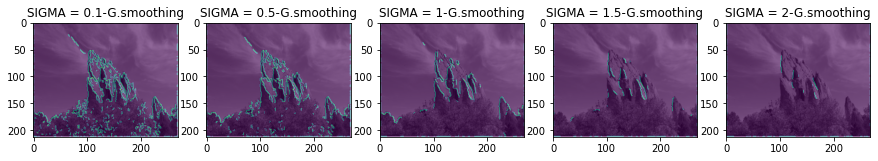

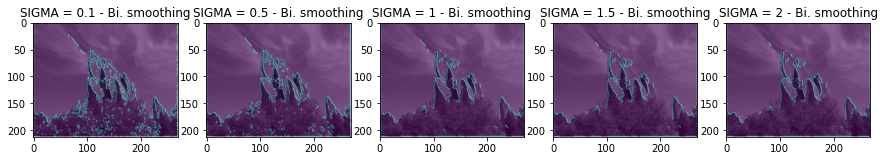

In [21]:
edge_1_bi = canny_edge_detector(img_resized,sigma=0.1,thresh_lo=0.1,thresh_hi=0.2,smoothing_type='bi')
edge_2_bi = canny_edge_detector(img_resized,sigma=0.5,thresh_lo=0.1,thresh_hi=0.2,smoothing_type='bi')
edge_3_bi = canny_edge_detector(img_resized,sigma=1,thresh_lo=0.1,thresh_hi=0.2,smoothing_type='bi')
edge_4_bi = canny_edge_detector(img_resized,sigma=1.5,thresh_lo=0.1,thresh_hi=0.2,smoothing_type='bi')
edge_5_bi = canny_edge_detector(img_resized,sigma=2,thresh_lo=0.1,thresh_hi=0.2,smoothing_type='bi')

plt.figure(figsize=(15,15))
plt.subplot(1,5,1)
plt.imshow(img_resized,cmap='gray')
plt.imshow(edge_1_gauss,alpha=0.6)
plt.title('SIGMA = 0.1-G.smoothing')

plt.subplot(1,5,2)
plt.imshow(img_resized,cmap='gray')
plt.imshow(edge_2_gauss,alpha=0.6)
plt.title('SIGMA = 0.5-G.smoothing')

plt.subplot(1,5,3)
plt.imshow(img_resized,cmap='gray')
plt.imshow(edge_3_gauss,alpha=0.6)
plt.title('SIGMA = 1-G.smoothing')

plt.subplot(1,5,4)
plt.imshow(img_resized,cmap='gray')
plt.imshow(edge_4_gauss,alpha=0.6)
plt.title('SIGMA = 1.5-G.smoothing')

plt.subplot(1,5,5)
plt.imshow(img_resized,cmap='gray')
plt.imshow(edge_5_gauss,alpha=0.6)
plt.title('SIGMA = 2-G.smoothing')

plt.figure(figsize=(15,15))
plt.subplot(1,5,1)
plt.imshow(img_resized,cmap='gray')
plt.imshow(edge_1_bi,alpha=0.6)
plt.title('SIGMA = 0.1 - Bi. smoothing')

plt.subplot(1,5,2)
plt.imshow(img_resized,cmap='gray')
plt.imshow(edge_2_bi,alpha=0.6)
plt.title('SIGMA = 0.5 - Bi. smoothing')

plt.subplot(1,5,3)
plt.imshow(img_resized,cmap='gray')
plt.imshow(edge_3_bi,alpha=0.6)
plt.title('SIGMA = 1 - Bi. smoothing')

plt.subplot(1,5,4)
plt.imshow(img_resized,cmap='gray')
plt.imshow(edge_4_bi,alpha=0.6)
plt.title('SIGMA = 1.5 - Bi. smoothing')

plt.subplot(1,5,5)
plt.imshow(img_resized,cmap='gray')
plt.imshow(edge_5_bi,alpha=0.6)
plt.title('SIGMA = 2 - Bi. smoothing')

We note that with bilateral smoothing we can more smooth the image and still preserve edges. Indeed with simga =2 the gaussian filtering remove all edges information whereas the bilateral smoothing still provide good information

## 3. Stitching two images


Let us load the images first.

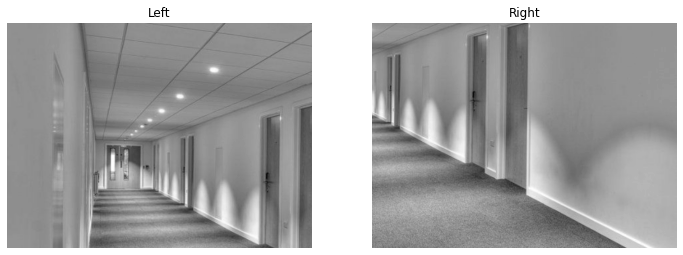

In [22]:
left_img   = cv2.imread('left.png')
left_img   = cv2.cvtColor(left_img, cv2.COLOR_RGB2GRAY)

right_img  = cv2.imread('right.png')
right_img  = cv2.cvtColor(right_img, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(left_img, cmap='gray')
plt.axis('off')
plt.title('Left')

plt.subplot(1, 2, 2)
plt.imshow(right_img, cmap='gray')
plt.axis('off')
plt.title('Right')

plt.show()

# Harris corner detector

Let's first implement a Harris corner detector

In [23]:
def compute_gradient(img):
    kernel_sobel_x =np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
    kernel_sobel_y =np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    
    sobel_x = convolve2d(img,kernel_sobel_x)
    sobel_y = convolve2d(img,kernel_sobel_y)
    
    return(sobel_x,sobel_y)

In [24]:
def harris(img):
    grad_x,grad_y=compute_gradient(img)    
    new_img = np.zeros(img.shape)
    shape= grad_x.shape

    for i in range(1,shape[0]-2):
        for j in range(1,shape[1]-2):
            H=np.zeros((2,2))
            for k in range (-1,2):
            #for k in range (0,1):
                for h in range (-1,2):
                #for h in range (0,1):
                    m=i+k
                    n=j+h
                    
                    H+=np.array([[grad_x[m][n]**2,grad_x[m][n]*grad_y[m][n]],[grad_x[m][n]*grad_y[m][n],grad_y[m][n]**2]])
                 
            
            tr = np.trace(H)
            det = np.linalg.det(H)
            
            f=det/(tr+0.000001)
            
            new_img[i][j]=f
    
    
    shape=new_img.shape
    new_img[-1,:]=np.zeros((1,shape[1]))
    new_img[0,:]=np.zeros((1,shape[1]))

    new_img[:,0]=np.zeros((1,shape[0]))
    new_img[:,-1]=np.zeros((1,shape[0]))      
    return(new_img)
       

In [25]:
def nonmax(harris):
    shape= harris.shape
    for i in range(1,shape[0]-2):
        for j in range(1,shape[1]-2):
            H=np.zeros((3,3))
            Z=np.zeros((3,3))
            for k in range (-1,2):  
                for h in range (-1,2):
                
                    m=i+k
                    n=j+h
                    har=harris[i+k][j+h]
                    H[k+1][h+1]=har
                  
            max_=H.max()
            argmax= np.argmax(H)
            Z=Z.reshape(1,9)
            Z[0][argmax]=max_
            Z=Z.reshape(3,3)
            harris[i-1:i+2,j-1:j+2]=Z
            
    return(harris)

In [26]:
def detect_corners(img,sigma,threshold):
    ## GAUSSIAN
    img_gauss = gaussian_filter(img,sigma)

    #HARRIS
    harris_img=harris(img_gauss)

    ## THRESHOLD
    t=1000


    mask = (np.array([harris_img>=t]).astype(int))[0]
    corners_threshold = (mask * harris_img)
    


    ## NON MAX
    non_max_harris=nonmax(corners_threshold)

    
    return(non_max_harris)

Let's visualise the result on the images 

In [27]:
left_img   = cv2.imread('left.png')
left_img   = cv2.cvtColor(left_img, cv2.COLOR_RGB2GRAY)
right_img  = cv2.imread('right.png')
right_img  = cv2.cvtColor(right_img, cv2.COLOR_RGB2GRAY)

corners_left = detect_corners(left_img,1.5,800)
corners_right = detect_corners(right_img,1.5,800)

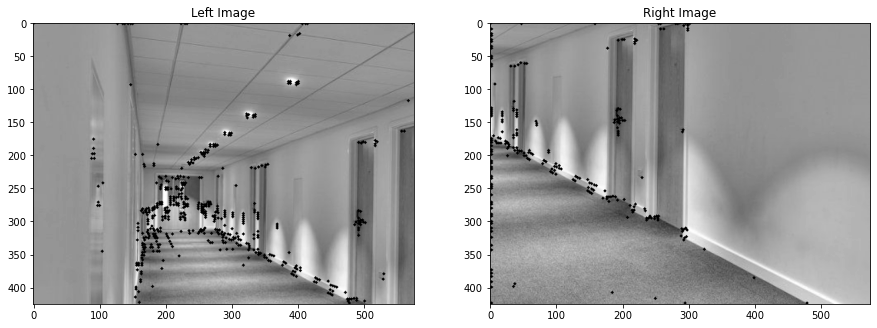

In [28]:
left_img   = cv2.imread('left.png')
left_img   = cv2.cvtColor(left_img, cv2.COLOR_RGB2GRAY)
right_img  = cv2.imread('right.png')
right_img  = cv2.cvtColor(right_img, cv2.COLOR_RGB2GRAY)

corners_right_non_zero_x=np.nonzero(corners_right)[0]
corners_right_non_zero_y=np.nonzero(corners_right)[1]

corners_left_non_zero_x=np.nonzero(corners_left)[0]
corners_left_non_zero_y=np.nonzero(corners_left)[1]

for i in zip(corners_right_non_zero_y,corners_right_non_zero_x):
    cv2.circle(right_img, i, radius=2, color=(0, 0, 255), thickness=-1)
    
for i in zip(corners_left_non_zero_y,corners_left_non_zero_x):
    cv2.circle(left_img, i, radius=2, color=(0, 0, 255), thickness=-1)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.title("Left Image")
plt.imshow(left_img,cmap='gray')
plt.subplot(1,2,2)
plt.title("Right Image")
plt.imshow(right_img,cmap='gray')

The algorithm is able detect interesting points wich could be potentail keypoints to realize a registration. But before trying to evaluate the quality of the registration associate with each pair of point, we need to be able to find the overlapping section in both images given a translation

Let's implement this block.

In [29]:
def select_random_corner(corners):
    corners_non_zero= corners[corners!=0]
   
    rand_int = np.random.randint(0,corners_non_zero.shape[0])
    selected_point_value =  corners_non_zero[rand_int]
 
    

    index_line=  np.where(corners == selected_point_value)[0][0]

    index_column=  np.where(corners == selected_point_value)[1][0]

    return(index_line,index_column)

def compute_translation(point_left,point_right):
    x_left=point_left[0]
    y_left=point_left[1]
    
    x_right=point_right[0]
    y_right=point_right[1]
    
    dx = x_right-x_left
    dy = y_right-y_left
    
    return(dx,dy)

def find_overlap(img,dx,dy):
    shape = img.shape
    over_lapping = np.zeros(shape)
    for i in range(0,shape[0]):
        for j in range(0,shape[1]):
            if ( (j+dy>=0) &(i+dx>=0) &(i+dx<shape[0])& (j+dy<shape[1])):
                
                over_lapping[i][j]=1
    return(over_lapping)

To test our ability to find overlapping region, let's select manually two equialent points in both image and extract the right & left overlapping region.

We choose :

- point_left=(300,490)
- point_right=(150,190)

Which correspond to a door section visible in both image. 

The points will be drawn in red. 

The estimated overlapping section wil be drawn in green



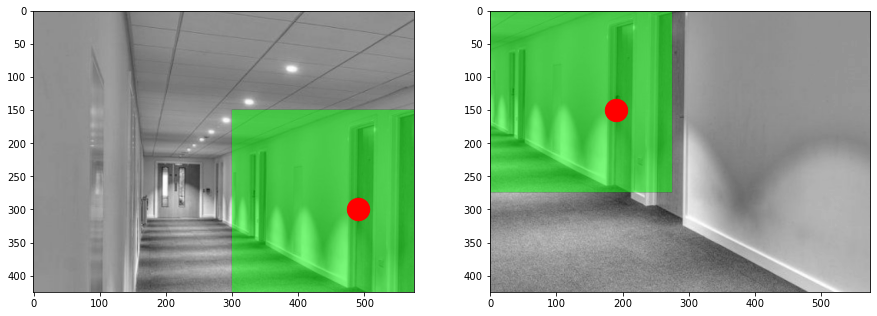

In [30]:
left_img   = cv2.imread('left.png')
left_img   = cv2.cvtColor(left_img, cv2.COLOR_RGB2GRAY)
right_img  = cv2.imread('right.png')
right_img  = cv2.cvtColor(right_img, cv2.COLOR_RGB2GRAY)

point_left=(300,490)
point_right=(150,190)


point_left_x=point_left[0]
point_left_y=point_left[1]

point_right_x=point_right[0]
point_right_y=point_right[1]





### overlapping
dx,dy = compute_translation(point_left,point_right)
shape = left_img.shape



over_lap_left= find_overlap(left_img,dx,dy)
over_lap_right= find_overlap(right_img,-dx,-dy)



dim = np.zeros(over_lap_left.shape)
Rl = np.stack((dim,over_lap_left, dim,over_lap_left/2), axis=2)

dim = np.zeros(over_lap_right.shape)
Rr = np.stack((dim,over_lap_right, dim,over_lap_right/2), axis=2)


plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(left_img,cmap='gray')
plt.imshow(Rl)
plt.scatter(point_left_y,point_left_x,s=500,color='red')
plt.subplot(1,2,2)
plt.imshow(right_img,cmap='gray')
plt.imshow(Rr)
plt.scatter(point_right_y,point_right_x,s=500,color='red')



We see that given a translation we can accuratly estimate the overlapping region in both images

Now let's create a function that extracts those regions. It will be usefull in order to compare them

In [31]:
def extract_region (img,overlapping_zone):

    first_zero_line = np.where(overlapping_zone==1)[0][0]
    first_zero_column = np.where(overlapping_zone==1)[1][0]

    last_zero_line = np.where(overlapping_zone==1)[0][-1]
    last_zero_column = np.where(overlapping_zone==1)[1][-1]
    
    extracted = img[first_zero_line:last_zero_line,first_zero_column:last_zero_column]

    return(extracted)


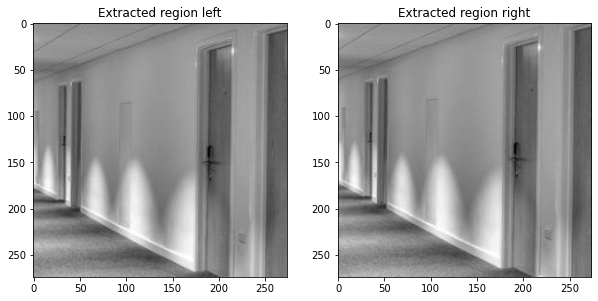

In [32]:
extracted_l=extract_region(left_img,over_lap_left)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title("Extracted region left")
plt.imshow(extracted_l,cmap='gray')


extracted_r=extract_region(right_img,over_lap_right)
plt.subplot(1,2,2)
plt.title("Extracted region right")
plt.imshow(extracted_r,cmap='gray')


#print(extracted_r.shape)
#print(extracted_l.shape)

Now that we have those 2 regions we can compute a similiratiry score between them which boils down to a sum of thresholded squared error 

In [33]:
def compute_similarity_score(region_right,region_left,treshold):
    shape = region_right.shape
    inliers = 0
    region_right=region_right/255
    region_left=region_left/255
    for i in range (0,shape[0]):
        for j in range (0,shape[1]):
            pixel_region_right = region_right[i][j]
            pixel_region_left = region_left[i][j]
            
            error = (pixel_region_right-pixel_region_left)**2
        
            if(error<treshold):
                inliers+=1
    return inliers

In [34]:
c=compute_similarity_score(extracted_r,extracted_l,0.015)
print("Number of inliers : ",c)
print("Inliers ratio : ",c/((extracted_r).shape[0]*(extracted_r).shape[1]),"%")


Number of inliers :  71964
Inliers ratio :  0.9585486706803772 %


As a biggers section obviously have more chance to have inliers, I find it more interesting to use the ratio of inliers compare to the size of the patches. 

To find the best pair of points between the 2 images, we use a stochastic method that compare random keypoint of the left image to random keypoint of the right image. For each pair a inliers ratio is computed. The pair with the higher ratio is the pair more likely to represent equivalent point. 

We should use the precise paire to estimate the translation between 2 images

In [35]:
def find_perfect_matched_point(corners_left,corners_right,threshold):
    
    resultat = np.zeros(right_img.shape)
    
    best_score = 0 
    
    for i in range(0,100):
        
    
        ## random points
        point_left= select_random_corner(corners_left)
        point_right= select_random_corner(corners_right)

        ## translation
        dx,dy = compute_translation(point_left,point_right)

        ### overlapping
        over_lap_left= find_overlap(left_img,dx,dy)
        over_lap_right= find_overlap(right_img,-dx,-dy)

        ## Extraction 

        extracted_left=extract_region(left_img,over_lap_left)
        extracted_right=extract_region(right_img,over_lap_right)

        ## Similarity score
        score = compute_similarity_score(extracted_right,extracted_left,threshold)
        
        #score=score/(extracted_left.shape[0]*extracted_left.shape[1])
        if(score/(extracted_left.shape[0]*extracted_left.shape[1])> best_score):
            res_right= point_right
            res_left = point_left
            best_score = score/(extracted_left.shape[0]*extracted_left.shape[1])
            
    return(res_right,res_left,best_score)

In [36]:
res_right, res_left,best_score = find_perfect_matched_point(corners_left,corners_right,0.015)

Now that we have the more likely pair of points, let's compute the translation and the overlapping regions associated  

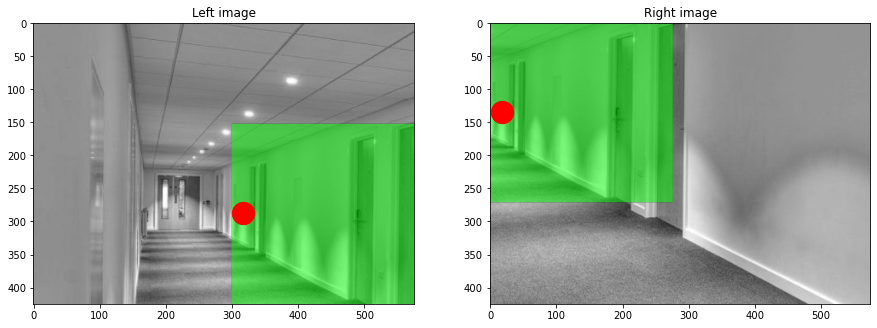

In [37]:
#point_left= selected_random_corner(corners_left)

#point_right= selected_random_corner(corners_right)

point_left=res_left
point_right=res_right

point_left_x=point_left[0]
point_left_y=point_left[1]

point_right_x=point_right[0]
point_right_y=point_right[1]





### overlapping
dx,dy = compute_translation(point_left,point_right)


shape = left_img.shape



over_lap_left= find_overlap(left_img,dx,dy)
over_lap_right= find_overlap(right_img,-dx,-dy)



dim = np.zeros(over_lap_left.shape)
Rl = np.stack((dim,over_lap_left, dim,over_lap_left/2), axis=2)

dim = np.zeros(over_lap_right.shape)
Rr = np.stack((dim,over_lap_right, dim,over_lap_right/2), axis=2)


plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.title("Left image")
plt.imshow(left_img,cmap='gray')
plt.imshow(Rl)
plt.scatter(point_left_y,point_left_x,s=500,color='red')
plt.subplot(1,2,2)
plt.title("Right image")
plt.imshow(right_img,cmap='gray')
plt.imshow(Rr)
plt.scatter(point_right_y,point_right_x,s=500,color='red')






We note that we have an accurate result with this stochastic method.

No let's try to sitch the images

# STICHTING 

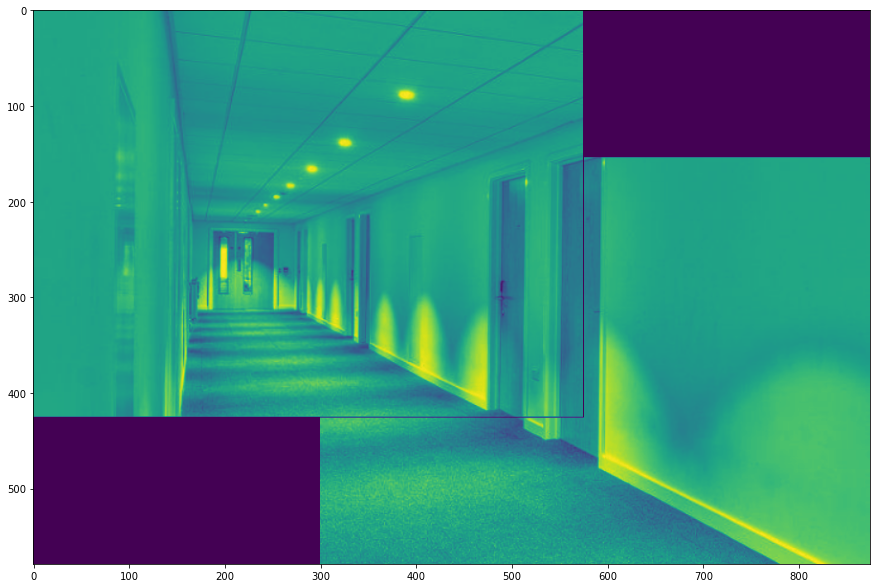

In [38]:
shape=left_img.shape
shape_x=shape[0]
shape_y=shape[1]

extracted_left=extract_region(left_img,over_lap_left)



shape_extracted = extracted_left.shape
shape_extracted_x=shape_extracted[0]
shape_extracted_y=shape_extracted[1]


stitched_img = np.zeros((2*shape_x-shape_extracted_x,2*shape_y-shape_extracted_y))





over_lap_right_inversed = np.array([over_lap_right!=1]).astype(int)[0]
right_img_no_extracted = right_img*over_lap_right_inversed



stitched_img[shape_x-shape_extracted_x:2*shape_x-shape_extracted_x,shape_y-shape_extracted_y:2*shape_y-shape_extracted_y]=right_img_no_extracted
stitched_img[:shape_x,:shape_y]=left_img



plt.figure(figsize=(15,15))
plt.imshow(stitched_img)


The result is pretty accurate.

In a real-world scenario we would need at least 4 pair of points to computer the homography between the images. Here the problem is reduced to a translation making it easier 